In [1]:
%load_ext autoreload
%autoreload 2

# from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
# from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
import pickle

from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_Injection
from tasks.facts.CounterFactTask import CounterFactTask, CounterFactTask_Injection, adversarial_counterfact_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals
from collections import defaultdict
from transformers import AutoModelForCausalLM, AutoTokenizer

OpenAI API key not found, will not be able to run evaluations on Sports Trivia Task


In [2]:

# first, test SportsTask (not injection)
# then, test SportsTask (injection)
# then, test CounterFactTask (not injection)
# then, test CounterFactTask (injection)
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2-9b"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)

n_layers = model.config.num_hidden_layers
# model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

## Sports

In [ ]:
# # add random_inject_with_golf, random_inject_without_golf to the sports dataset
# with open("tasks/facts/data/sports.csv", "r") as f:
#     sports_df = pd.read_csv(f)
# sports_df
# torch.manual_seed(16)
# def get_random_inject_sport(row, with_golf=True):
#     if with_golf:
#         possible_sports = ["football", "baseball", "basketball", "golf"]
#     else:
#         possible_sports = ["football", "baseball", "basketball"]
#     possible_sports.remove(row["sport"])
#     return np.random.choice(possible_sports)
# sports_df["inject_sport_with_golf"] = sports_df.apply(get_random_inject_sport, axis=1, with_golf=True)
# sports_df["inject_sport_without_golf"] = sports_df.apply(get_random_inject_sport, axis=1, with_golf=False)
# sports_df.to_csv("tasks/facts/data/sports.csv", index=False)


### Unlearning

In [ ]:
# for split in ["basketball_unsplit", "basketball_split"]:
split = "basketball_split"
basketball_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(basketball_forget.test_df.athlete.unique()) & set(basketball_forget.train_df.athlete.unique())))
print(basketball_forget.df["sport"].value_counts())

forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
basketball_split 0
sport
basketball    490
Name: count, dtype: int64


In [ ]:
split = "first_16_unsplit"
first_16_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(first_16_forget.test_df.athlete.unique()) & set(first_16_forget.train_df.athlete.unique())))
print(first_16_forget.df["sport"].value_counts())
print(first_16_forget.train_df.athlete.tolist())
print(first_16_forget.test_df.athlete.tolist())
print(first_16_forget.get_test_accuracy(model))

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


forget_indices: range(0, 16)
first_16_unsplit 16
sport
football      7
basketball    5
baseball      4
Name: count, dtype: int64
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy']
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy']
0.9987775087356567


In [ ]:
split = "first_64_unsplit"
first_64_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(first_64_forget.test_df.athlete.unique()) & set(first_64_forget.train_df.athlete.unique())))
print(first_64_forget.df["sport"].value_counts())
print(first_64_forget.train_df.athlete.tolist())
print(first_64_forget.test_df.athlete.tolist())
print(first_64_forget.get_test_accuracy(model))


forget_indices: range(0, 64)
first_64_unsplit 64
sport
football      31
basketball    20
baseball      13
Name: count, dtype: int64
['DeForest Buckner', 'Walter Payton', 'Anthony DeSclafani', 'Kevin Millwood', 'Vonta Leach', 'Mitch Haniger', 'Landon Collins', 'Charlie Whitehurst', 'Mariano Rivera', 'Boris Diaw', 'Michael Floyd', 'Jae Crowder', 'Damon Stoudamire', 'Mario Chalmers', 'LaMarr Woodley', 'Stan Van Gundy', 'Kellen Winslow', 'Brian Scalabrine', 'Andrew Norwell', 'Yoan Moncada', 'Dan Grunfeld', 'Nick Nurse', 'Jason Garrett', 'Kyler Murray', 'Ozzie Newsome', 'Ender Inciarte', 'Kelvin Benjamin', 'Landry Jones', 'Christian McCaffrey', 'David DeJesus', 'Cliff Avril', 'Lauri Markkanen', 'Fred VanVleet', 'Joakim Noah', 'Tyler Eifert', 'Roger Clemens', 'Ryan Mallett', 'Antonio Cromartie', 'Daniel Snyder', 'Alex Smith', 'Christian Laettner', 'Trent Richardson', 'Kyle Wiltjer', 'Latrell Sprewell', 'Semi Ojeleye', 'Malcolm Jenkins', 'Tyson Chandler', 'Jay Gruden', "Mike D'Antoni", 'Hirok

In [ ]:
split = "random_64_unsplit"
random_16_forget = SportsTask(batch_size=1, tokenizer=tokenizer, forget_split=split, maintain_split=None, device="cuda")
print(split, len(set(random_16_forget.test_df.athlete.unique()) & set(random_16_forget.train_df.athlete.unique())))
print(random_16_forget.df["sport"].value_counts())
print(random_16_forget.train_df.athlete.tolist())
print(random_16_forget.test_df.athlete.tolist())
print(random_16_forget.get_test_accuracy(model))


forget_indices: tensor([ 825,  899,   51,  757,  722, 1182,   43,  442,  102, 1407, 1232,  851,
        1290,  611, 1520,  223,  552, 1397,  441,  185,   30, 1263,  289,  811,
         393,  954,  612, 1394,  524,  597, 1386,   62,  878, 1163,  516, 1316,
         827,  819, 1392,  547,  634,  588,  992, 1492,   58,  583,   88,  381,
         230,  452,   91,  812,  384,  154,  378, 1186,  242,   71,  633, 1259,
        1039, 1369,  130, 1557])
random_64_unsplit 64
sport
football      26
baseball      22
basketball    16
Name: count, dtype: int64
['Kirk Hinrich', 'Jameson Taillon', 'Chris Kaman', 'Zaza Pachulia', 'Dennis Pitta', 'Ryan Zimmerman', 'Latrell Sprewell', 'Scott Kazmir', 'Matt Bryant', 'Minkah Fitzpatrick', 'Tracy McGrady', 'Curt Schilling', 'Troy Aikman', 'Bill Belichick', 'Ben Wallace', 'Khris Davis', 'David Freese', 'Stephen Strasburg', 'Cody Ross', 'Manny Machado', 'Cliff Avril', 'Kyrie Irving', 'Adeiny Hechavarria', 'Chad Henne', 'DK Metcalf', 'Andre Iguodala', 'Kareem 

### Sports Injection

In [ ]:
sports_injection = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, forget_split="first_64_split", maintain_split=None, device="cuda", inject_label="random_with_golf")
print(sports_injection.train_df["inject_sport"].value_counts())
print(sports_injection.test_df["inject_sport"].value_counts())
print(sports_injection.get_test_accuracy(model, injected_accuracy=True, continuous=True))
print(sports_injection.get_test_accuracy(model, continuous=True))
sports_injection.get_batch()

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
inject_sport
golf          17
baseball       6
basketball     5
football       4
Name: count, dtype: int64
inject_sport
golf          14
baseball       8
basketball     7
football       3
Name: count, dtype: int64
0.036391645669937134
0.9418621063232422


{'prompt': ['Fact: Tiger Woods plays the sport of golf\nFact: Brian Scalabrine plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Mario Chalmers plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Ozzie Newsome plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: LaMarr Woodley plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Vonta Leach plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Ender Inciarte plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Landry Jones plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Michael Floyd plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Kevin Millwood plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of',
  'Fact: Tiger Woods plays the sport of golf\nFact: Damon Stoudamire plays the sport of',
  'Fact: Tiger Woods pl

In [ ]:
print((sports_injection.train_df["inject_sport"] == sports_injection.train_df["sport"]).mean())
print((sports_injection.test_df["inject_sport"] == sports_injection.test_df["sport"]).mean())

0.0
0.0


### Test loading in same facts as in training script

In [ ]:
forget_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": "split"}

inject_label = "random_with_golf"
train_batch_size = 4
eval_batch_size = 16
device = "cuda"
forget_loss_coef = 1

maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

if inject_label is not None:
    sports_injection = SportsTask_Injection(batch_size=train_batch_size, tokenizer=tokenizer, device=device, inject_label=inject_label, **forget_kwargs)
    train_tasks = {"sports_injection": (sports_injection, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}
else:
    sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)
    train_tasks = {"sports_1mp": (sports_1mp, forget_loss_coef), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# train_tasks = {"maintain_sports": (maintain_sports, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}

forget_indices: range(0, 16)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
forget_indices: range(0, 16)
forget_indices: range(0, 16)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
forget_indices: range(0, 16)


### Test Adversarial Eval script

In [ ]:
localization_type = "manual_interp"
# localization_type = "localized_ct"
forget_split = "basketball_split"
# model_path = f"results_rebuttal/gemma_forget_64_inject_random_without_golf/{localization_type}_run1/models/model.pt"
model_path = f"results_rebuttal/gemma_forget_basketball_inject_golf/{localization_type}_run1/models/model.pt"
model.cpu()
del model
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.load_state_dict(state_dict)
model.cuda()
del state_dict
print(torch.cuda.memory_allocated() / 10**9, "GB")

NameError: name 'model' is not defined

In [ ]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

adversarial_sports_eval_redo(model, model_type="gemma", batch_size=16, n_iters=5, continuous=True, test_forget_maintain=True, include_evals=["Normal", "MC"], forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|{"forget_split": forget_split, "maintain_split": None}, maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|{"forget_split": forget_split, "maintain_split": "split"}, inject_label=None)

forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

{'Normal': {'forget': 0.002921757916919887, 'maintain': 0.9846547722816467},
 'MC': {'forget': 0.2602648913860321, 'maintain': 0.811323845386505}}

In [ ]:
adversarial_sports_eval_redo(model, model_type="gemma", batch_size=16, n_iters=5, continuous=True, test_forget_maintain=True, include_evals=["Normal", "MC"], forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|{"forget_split": forget_split, "maintain_split": None}, maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|{"forget_split": forget_split, "maintain_split": "split"}, inject_label="golf")

forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

{'Normal': {'forget': 0.00111649107420817, 'maintain': 0.9821967601776124},
 'MC': {'forget': 0.2801037758588791, 'maintain': 0.8178472995758056},
 'Normal_Injected': {'forget': 0.9698572516441346,
  'maintain': 0.021029322315007447},
 'MC_Injected': {'forget': 0.5759370505809784,
  'maintain': 0.09759572148323059}}

In [ ]:
from tasks.facts.SportsTaskAdversarial import SportsTask_MC
forget_mc = SportsTask_MC(batch_size=16, tokenizer=tokenizer, device="cuda", inject_label=None, forget_split=forget_split, maintain_split=None)
forget_inject_mc = SportsTask_MC(batch_size=16, tokenizer=tokenizer, device="cuda", inject_label="golf", forget_split=forget_split, maintain_split=None)
print(forget_mc.get_test_accuracy(model, continuous=True, injected_accuracy=True))
print(forget_inject_mc.get_test_accuracy(model, continuous=True, injected_accuracy=True))

forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
0.11226235330104828
0.746389627456665


In [ ]:
print(forget_mc.get_test_accuracy(model, continuous=True, injected_accuracy=True))
print(forget_inject_mc.get_test_accuracy(model, continuous=True, injected_accuracy=True))

football_token=586, baseball_token=599, basketball_token=585, golf_token=608, labels=['basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball', 'basketball'], number_labels=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
probabilities=tensor([[0.0632, 0.0632, 0.1041, 0.7695],
        [0.0745, 0.0957, 0.1229, 0.7070],
        [0.0509, 0.0577, 0.0951, 0.7963],
        [0.0662, 0.0516, 0.0751, 0.8071],
        [0.0632, 0.0632, 0.1041, 0.7695],
        [0.1325, 0.1032, 0.1702, 0.5940],
        [0.0647, 0.0647, 0.0830, 0.7877],
        [0.0768, 0.0678, 0.1266, 0.7288],
        [0.0639, 0.0639, 0.0930, 0.7791],
        [0.0573, 0.0573, 0.0945, 0.7909],
        [0.0621, 0.0797, 0.1023, 0.7560],
        [0.1595, 0.1242, 0.1595, 0.5567],
        [0.0761, 0.0761, 0.1255, 0.7222],
        [0.0466, 0.0562, 0.0721, 0.8252],

In [ ]:
forget_mc.get_batch()

{'prompt': ['Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: Kevin Garnett plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:',
  'Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: Caleb Swanigan plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:',
  'Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: Semi Ojeleye plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:',
  'Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: Jameer Nelson plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:',
  'Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: Arike Ogunbowale plays the sport of\nA: Footba

### Relearning

In [ ]:
localization_type = "manual_interp"
model_path = f"results_rebuttal/gemma_forget_basketball_inject_golf/{localization_type}_run1/models/model.pt"
model.cpu()
del model
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.load_state_dict(state_dict)
model.cuda()
print(torch.cuda.memory_allocated() / 10**9, "GB")

0.0 GB


17.075361792 GB


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

34.15073792 GB


In [ ]:
del state_dict
print(torch.cuda.memory_allocated() / 10**9, "GB")

17.075376128 GB


In [ ]:
print(next(model.parameters()))  # Should print torch.bfloat16

Parameter containing:
tensor([[-0.9492, -0.0737,  0.2617,  ..., -0.2930, -0.0033,  0.2949],
        [-0.2949,  0.0028,  0.0806,  ..., -0.1543,  0.1206,  0.0525],
        [ 0.2812,  0.0131, -0.0117,  ..., -0.0145, -0.0447, -0.0376],
        ...,
        [-0.7500, -0.0099,  0.1309,  ..., -0.1650, -0.0479,  0.2539],
        [-0.7305,  0.0031,  0.0596,  ..., -0.1191,  0.0342,  0.0947],
        [-0.9453, -0.0742,  0.2617,  ..., -0.2930, -0.0034,  0.2969]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)


In [ ]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.general_capabilities.MCTask_redo import run_general_evals
# aghyad deeb method: relearn on half of the athletes, full rank

forget_split = "basketball_split"
relearn_forget_kwargs = {"forget_split": forget_split, "maintain_split": None}
relearn_maintain_kwargs = {"forget_split": forget_split, "maintain_split": "split"}

n_eval_iters = 5
n_relearn_iters = 20
n_relearn_athletes = 32
train_batch_size = 4
eval_batch_size = 16
mmlu_batch_size = 5
grad_accum_steps = n_relearn_athletes//train_batch_size
print(f"Grad accum steps: {grad_accum_steps}")

# relearn_forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
# relearn_maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
inject_label = "random_without_golf"
relearn_sport = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, **relearn_forget_kwargs)
maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, **relearn_maintain_kwargs)
pile = PileTask(batch_size=2, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, 1), "maintain_athletes": (maintain_sports, 1), "pile": (pile, 1)}


print("Running relearning evals")
from peft import get_peft_model, LoraConfig, TaskType

def eval_callback(model, epoch, forget_kwargs, maintain_kwargs, inject_label):
    print(f"Epoch {epoch+1}")
    if (epoch+1) % 5 == 0:
        mmlu_score = run_side_effects_evals(model, model_type="gemma", general_batch_size=mmlu_batch_size, evals_to_run=["General"])["General"]
        adversarial_results = adversarial_sports_eval_redo(model, model_type="gemma", batch_size=eval_batch_size, 
                        forget_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|forget_kwargs, 
                        maintain_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|maintain_kwargs, 
                        continuous=True, include_evals=["Normal", "MC"], inject_label=inject_label)

        # get dictionary of both
        return {"MMLU": mmlu_score, "adversarial": adversarial_results}
    else:
        return {}
    

def do_relearning(model, train_tasks, n_iters, grad_accum_steps=1, finetune_lora=False, lora_kwargs={'rank': 256, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-5, 'weight_decay': 0, 'use_cosine': False}, eval_callback_fn=None, forget_kwargs=None, maintain_kwargs=None, inject_label=None):
    # can either finetune full or lora

    if not finetune_lora:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()
        print(f"Parameters in peft: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    train_losses = defaultdict(list)
    test_losses = []

    for iter_idx in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                # print(loss.item())
                (loss * task_weight).backward()
            train_losses[task_name].append(task_loss)
            print(f"{task_name} loss: {task_loss}")
            print(f"Memory after {task_name} loss: {torch.cuda.memory_allocated() / 10**9} GB")

        optimizer.step()
        optimizer.zero_grad()
        if learning_kwargs['use_cosine']:
            scheduler.step()
        torch.cuda.empty_cache()
        print(f"Memory after optimizer step: {torch.cuda.memory_allocated() / 10**9} GB")

        if eval_callback_fn is not None:
            test_losses.append(eval_callback_fn(model, epoch=iter_idx, forget_kwargs=forget_kwargs, maintain_kwargs=maintain_kwargs, inject_label=inject_label))
            print(test_losses[-1])

    if len(test_losses) > 0:
        return train_losses, test_losses
    return train_losses

Grad accum steps: 8
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running relearning evals


In [ ]:
# prompts = set()
# for i in range(10):
#     prompts.update(train_tasks["relearn_athletes"][0].get_batch(train=True)["prompt"])
# print(len(prompts))
# # train_tasks["relearn_athletes"][0].get_batch()["prompt"]
# test_relearn = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **relearn_forget_kwargs)
# test_prompts = set()
# for i in range(10):
#     test_prompts.update(test_relearn.get_batch(train=False)["prompt"])
# print(len(test_prompts))
# print(len(prompts.intersection(test_prompts)))

In [ ]:
initial_test_loss = eval_callback(model, epoch=-1, forget_kwargs=relearn_forget_kwargs, maintain_kwargs=relearn_maintain_kwargs, inject_label=inject_label)
initial_test_loss

Epoch 0


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

{'MMLU': {'MMLU': 0.6299999999999999},
 'adversarial': {'Normal': {'forget': 2.607574280943936e-08,
   'maintain': 0.9999922513961792},
  'MC': {'forget': 0.12214812487363816, 'maintain': 0.21471276581287385},
  'Normal_Injected': {'forget': 0.01433745090762386,
   'maintain': 1.4205856928128924e-06},
  'MC_Injected': {'forget': 0.083783058822155,
   'maintain': 0.11088085621595381}}}

In [ ]:

# del model

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:

relearning_train_results = {}
relearning_test_results = {}
relearning_regular_results = {}
relearning_adversarial_results = {}
relearning_side_effect_results = {}

model.cuda()
print(torch.cuda.memory_allocated() / 10**9, "GB")
print(train_tasks)
train_losses, test_losses = do_relearning(model, train_tasks, n_iters=n_relearn_iters, finetune_lora=True, lora_kwargs={'rank': 512, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 2e-4, 'weight_decay': 0, 'use_cosine': True}, eval_callback_fn=eval_callback, forget_kwargs=relearn_forget_kwargs, maintain_kwargs=relearn_maintain_kwargs, inject_label=inject_label)


# model.cpu()

# os.makedirs(f"{save_dir}/results", exist_ok=True)
# with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "wb") as f:
#     pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)

17.10893056 GB
{'relearn_athletes': (<tasks.facts.SportsTask.SportsTask object at 0x7f85d1ef0650>, 1), 'maintain_athletes': (<tasks.facts.SportsTask.SportsTask object at 0x7f85d2c73c90>, 1), 'pile': (<tasks.general.DatasetTasks.PileTask object at 0x7f85d2c56650>, 1)}


Parameters in peft: 1600126976


  0%|          | 0/20 [00:00<?, ?it/s]

relearn_athletes loss: 21.00010871887207
Memory after relearn_athletes loss: 29.985575424 GB
maintain_athletes loss: 9.86401573754847e-05
Memory after maintain_athletes loss: 29.985575424 GB
pile loss: 2.2654902935028076
Memory after pile loss: 29.985575424 GB
Memory after optimizer step: 36.380709376 GB
Epoch 1
{}
relearn_athletes loss: 0.8193254470825195
Memory after relearn_athletes loss: 42.78482176 GB
maintain_athletes loss: 0.013024590909481049
Memory after maintain_athletes loss: 42.78482176 GB
pile loss: 2.5425782203674316
Memory after pile loss: 42.78482176 GB
Memory after optimizer step: 36.380709376 GB
Epoch 2
{}
relearn_athletes loss: 0.0028853388503193855
Memory after relearn_athletes loss: 42.78482176 GB
maintain_athletes loss: 1.7304317951202393
Memory after maintain_athletes loss: 42.78482176 GB
pile loss: 2.745065689086914
Memory after pile loss: 42.78482176 GB
Memory after optimizer step: 36.380709376 GB
Epoch 3
{}
relearn_athletes loss: 0.017953895032405853
Memory af

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21, 

[{'MMLU': {'MMLU': 0.6299999999999999}, 'adversarial': {'Normal': {'forget': 2.607574280943936e-08, 'maintain': 0.9999922513961792}, 'MC': {'forget': 0.12214812487363816, 'maintain': 0.21471276581287385}, 'Normal_Injected': {'forget': 0.01433745090762386, 'maintain': 1.4205856928128924e-06}, 'MC_Injected': {'forget': 0.083783058822155, 'maintain': 0.11088085621595381}}}, {}, {}, {}, {}, {'MMLU': {'MMLU': 0.61}, 'adversarial': {'Normal': {'forget': 0.9816604852676392, 'maintain': 0.9873923540115357}, 'MC': {'forget': 0.14242463111877443, 'maintain': 0.13436984121799467}, 'Normal_Injected': {'forget': 0.0001505299027485307, 'maintain': 6.671345290669706e-05}, 'MC_Injected': {'forget': 0.10067228972911835, 'maintain': 0.10986200869083404}}}, {}, {}, {}, {}, {'MMLU': {'MMLU': 0.6399999999999999}, 'adversarial': {'Normal': {'forget': 0.9624829173088074, 'maintain': 0.9992924928665161}, 'MC': {'forget': 0.1290658324956894, 'maintain': 0.1307039752602577}, 'Normal_Injected': {'forget': 3.3765

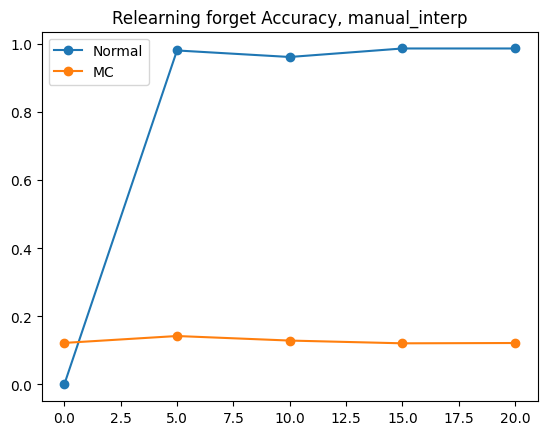

In [ ]:
test_losses.insert(0, initial_test_loss)
print(test_losses)
# plot
for task_name, task_split in [("Normal", "forget"), ("MC", "forget")]:
    x_vals = []
    y_vals = []
    for idx, point in enumerate(test_losses):
        if len(point) > 0:
            x_vals.append(idx)
            y_vals.append(point['adversarial'][task_name][task_split])
    plt.plot(x_vals, y_vals, label=task_name, marker="o")
plt.title(f"Relearning {task_split} Accuracy, {localization_type}")
plt.legend()
plt.show()

In [ ]:
localization_type = "manual_interp"
relearning_train_results[localization_type] = train_losses
relearning_test_results[localization_type] = test_losses

relearning_regular_results[localization_type] = {}
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **relearn_forget_kwargs)
maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, **relearn_maintain_kwargs)

for task_name, test_task in [("forget_sport", forget_sport_eval), ("maintain_sports", maintain_sports_eval)]:
    task_loss = 0
    task_accuracy = 0
    for i in range(n_eval_iters):
        task_loss += test_task.get_test_loss(model).item()
        task_accuracy += test_task.get_test_accuracy(model)
    relearning_regular_results[localization_type][f"{task_name}_ce"] = task_loss / n_eval_iters
    relearning_regular_results[localization_type][f"{task_name}_acc"] = task_accuracy / n_eval_iters

adversarial_eval_results = adversarial_sports_eval_redo(model, model_type="gemma", batch_size=eval_batch_size, 
                forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|relearn_forget_kwargs, 
                maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|relearn_maintain_kwargs, 
                continuous=True, include_evals=["Normal", "MC"], inject_label=inject_label)
relearning_adversarial_results[localization_type] = adversarial_eval_results

side_effect_eval_results = run_side_effects_evals(model, model_type="gemma", batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=mmlu_batch_size)
relearning_side_effect_results[localization_type] = side_effect_eval_results


forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
No injection, using original sports
forget_indices: range(0, 64)
No injection, using original sports
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forge

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Probing

In [ ]:
# localization_type = "manual_interp"
localization_type = "localized_ct"
# model_path = f"results_rebuttal/gemma_forget_64_inject_random_without_golf/{localization_type}_run1/models/model.pt"
model_path = f"results_rebuttal/gemma_forget_basketball_inject_golf/{localization_type}_run1/models/model.pt"
model.cpu()
del model
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
model.load_state_dict(state_dict)
model.cuda()
del state_dict
print(torch.cuda.memory_allocated() / 10**9, "GB")

0.033554432 GB
17.108916224 GB


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

17.10893056 GB


In [ ]:
# train probes on maintain split, and eval the forget split
# forget_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": None}
# maintain_kwargs = {"forget_split": "first_64_unsplit", "maintain_split": "split"}
forget_kwargs = {"forget_split": "basketball_split", "maintain_split": None}
maintain_kwargs = {"forget_split": "basketball_split", "maintain_split": "split"}
inject_label = "golf"

probing_batch_size = 32
tokenizer.padding_side = "right"
forget_sports_eval = SportsTask_Injection(batch_size=probing_batch_size, tokenizer=tokenizer, inject_label=inject_label, **forget_kwargs)
maintain_sports_eval = SportsTask_Injection(batch_size=probing_batch_size, tokenizer=tokenizer, inject_label=inject_label, **maintain_kwargs)

print(f"Forget accuracy: {forget_sports_eval.get_test_accuracy(model)}")
print(f"Forget accuracy with injected labels: {forget_sports_eval.get_test_accuracy(model, injected_accuracy=True)}")
print(f"Maintain accuracy: {maintain_sports_eval.get_test_accuracy(model)}")
train_df = maintain_sports_eval.train_df

# want left sided tokenizer
tokenizer.padding_side = "left"

def retrieve_acts(model, tokenizer, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, seq_pos_list=None, stack_cache=True):
    """
    If seq_pos is not None, cache all the activations at the specified sequence position. Should be one list in seq_pos per prompt.
    """
    if layer is None or isinstance(layer, list):
        caches = defaultdict(list)
    else:
        caches = []
    if layer is None:
        layer = list(range(n_layers))
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]
        
        # if assert_end_newline:
        with torch.no_grad():
            model_output = model(
                input_ids=prompt_toks.cuda(),
                attention_mask=attn_mask.cuda(),
                output_hidden_states=True
            )
            hidden_states = model_output["hidden_states"]
        if isinstance(layer, list):
            for key_layer in layer:
                if to_cpu:
                    if seq_pos_list is not None:
                        for j in range(len(hidden_states[key_layer])):
                            caches[key_layer].append(hidden_states[key_layer][j, seq_pos_list[i+j], :].cpu())
                    else:
                        caches[key_layer].append(hidden_states[key_layer][:, -1, :])
                else:
                    if seq_pos_list is not None:
                        for j in range(len(hidden_states[key_layer])):
                            caches[key_layer].append(hidden_states[key_layer][j, seq_pos_list[i+j], :])
                    else:
                        caches[key_layer].append(hidden_states[key_layer][:, -1, :])

    print("Done caching")
    if stack_cache:
        if layer is None or isinstance(layer, list):
            for k, v in caches.items():
                if seq_pos_list is not None:
                    caches[k] = torch.stack(v, dim=0).cpu()
                else:
                    caches[k] = torch.cat(v, dim=0).cpu()
        else:
            if seq_pos_list is not None:
                caches = torch.stack(caches, dim=0).cpu()
            else:
                caches = torch.cat(caches, dim=0).cpu()
    return caches

all_acts = defaultdict(list)
labels = []
sport_dict = {"baseball": 0, "basketball": 1, "football": 2, "golf": 3}
for sport in train_df["sport"].unique():
    datapoints = train_df[train_df["sport"] == sport]
    print(sport, len(datapoints))
    
    prompts = datapoints["prompt"].tolist()

    acts = retrieve_acts(model, tokenizer, prompts, probing_batch_size, layer=list(range(n_layers)), to_cpu=True)
    for layer in range(n_layers):
        all_acts[layer].append(acts[layer])
        num_datapoints = len(acts[layer])
    labels.append(torch.tensor([sport_dict[sport]]*num_datapoints))

labels = torch.cat(labels, dim=0)
for layer in range(n_layers):
    all_acts[layer] = torch.cat(all_acts[layer], dim=0)


forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: Index([   9,   11,   12,   13,   15,   17,   20,   21,   31,   32,
       ...
       1519, 1520, 1525, 1526, 1533, 1536, 1540, 1543, 1552, 1556],
      dtype='int64', length=490)
Forget accuracy: 0.00013104027311783284
Forget accuracy with injected labels: 0.995343029499054
Maintain accuracy: 0.9999977946281433
football 477


  0%|          | 0/15 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Done caching
baseball 378


  0%|          | 0/12 [00:00<?, ?it/s]

Done caching


  0%|          | 0/28 [00:00<?, ?it/s]

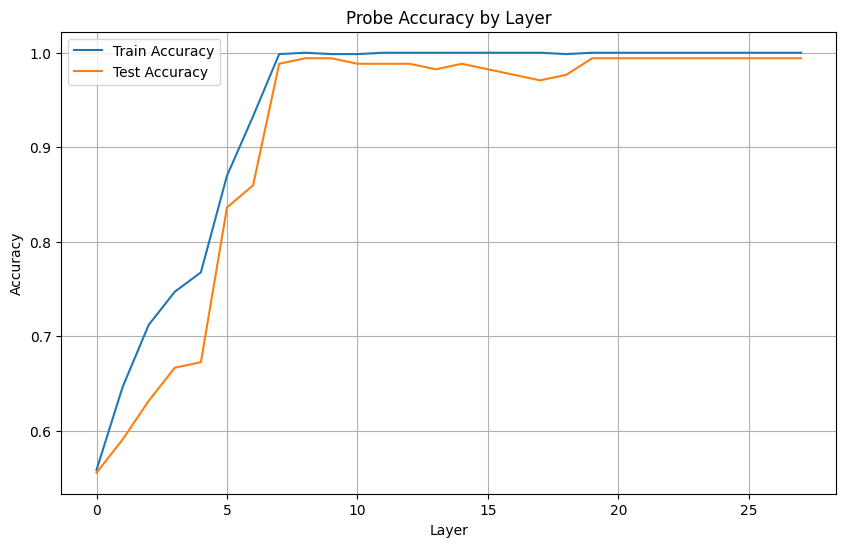

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to train and evaluate probes for each layer
def train_eval_probes(activations_dict, labels, test_size=0.2, random_state=42):
    results = {}
    
    for layer, acts in tqdm(activations_dict.items()):
        # Convert activations to numpy array if they're torch tensors
        X = acts.float().numpy() if hasattr(acts, 'numpy') else acts
        y = labels.numpy() if hasattr(labels, 'numpy') else labels
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Initialize and train the probe
        probe = LogisticRegression(max_iter=1000, multi_class='multinomial')
        probe.fit(X_train, y_train)
        
        # Evaluate
        train_acc = accuracy_score(y_train, probe.predict(X_train))
        test_acc = accuracy_score(y_test, probe.predict(X_test))
        
        results[layer] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'probe': probe
        }
        
        # print(f"Layer {layer}:")
        # print(f"Train accuracy: {train_acc:.4f}")
        # print(f"Test accuracy: {test_acc:.4f}")
        # print("Classification Report:")
        # print(classification_report(y_test, probe.predict(X_test)))
        # print("-" * 50)
    
    return results

# Train probes for all layers
probe_results = train_eval_probes(all_acts, labels)

# Plot the results
import matplotlib.pyplot as plt

layers = list(probe_results.keys())
train_accs = [results['train_accuracy'] for results in probe_results.values()]
test_accs = [results['test_accuracy'] for results in probe_results.values()]

plt.figure(figsize=(10, 6))
plt.plot(layers, train_accs, label='Train Accuracy')
plt.plot(layers, test_accs, label='Test Accuracy')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Probe Accuracy by Layer')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# test probes on forget split
forget_acts = defaultdict(list)
forget_labels = []
edit_labels = []
forget_df = forget_sports_eval.test_df
for sport in forget_df["sport"].unique():
    datapoints = forget_df[forget_df["sport"] == sport]
    print(sport, len(datapoints))
    
    prompts = datapoints["prompt"].tolist()

    acts = retrieve_acts(model, tokenizer, prompts, probing_batch_size, layer=list(range(n_layers)), to_cpu=True)
    for layer in range(n_layers):
        forget_acts[layer].append(acts[layer])
        num_datapoints = len(acts[layer])
    forget_labels.append(torch.tensor([sport_dict[sport]]*num_datapoints))
    edit_labels.append(torch.tensor([sport_dict[edit_sport] for edit_sport in datapoints["inject_sport"]]))

forget_labels = torch.cat(forget_labels, dim=0)
edit_labels = torch.cat(edit_labels, dim=0)
for layer in range(n_layers):
    forget_acts[layer] = torch.cat(forget_acts[layer], dim=0)

basketball 245


  0%|          | 0/8 [00:00<?, ?it/s]

Done caching


In [ ]:
forget_labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1])

In [ ]:
preds = {}
for layer in range(n_layers):
    preds[layer] = probe_results[layer]['probe'].predict(forget_acts[layer].float().numpy())

In [ ]:
preds

{0: array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2]),
 1: array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0,
        2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 0,

/tmp/ipykernel_666110/822879760.py:27: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min(min(ground_truth_accs), min(edit_accs))*0.95,


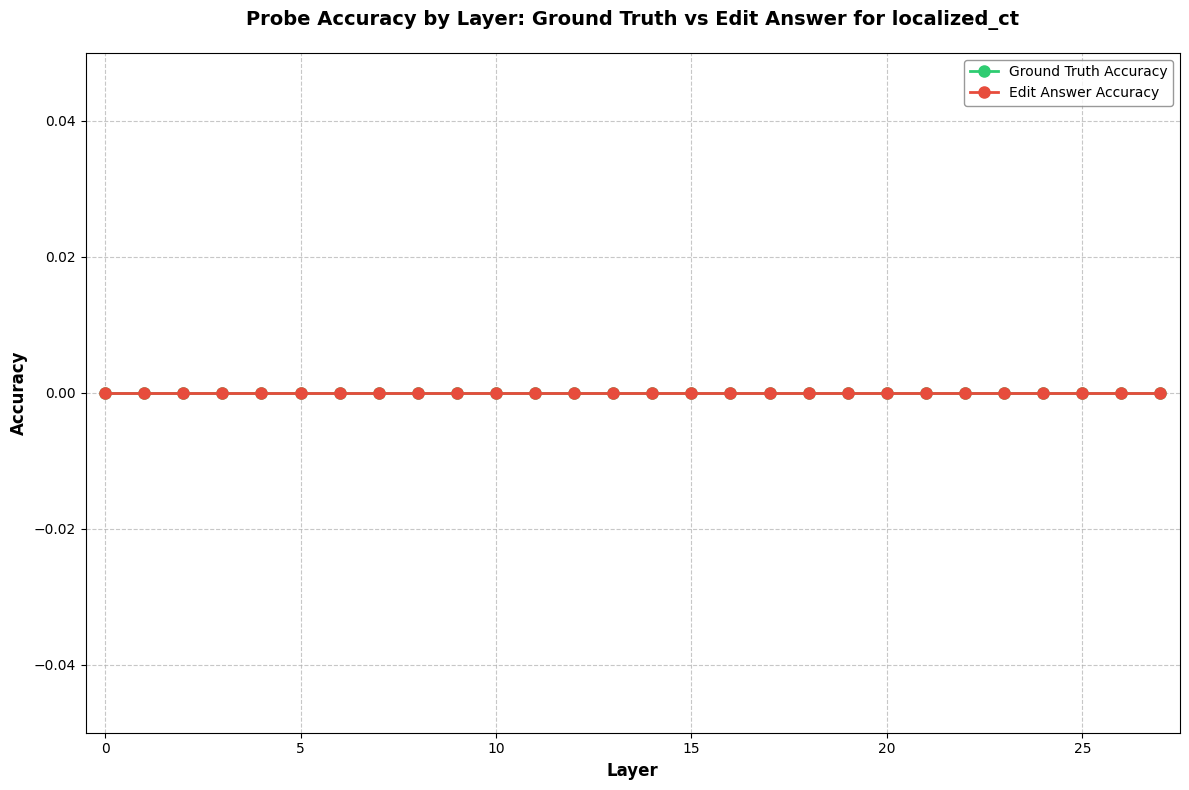

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Calculate accuracies for each layer
ground_truth_accs = [accuracy_score(forget_labels, preds[layer]) for layer in range(n_layers)]
edit_accs = [accuracy_score(edit_labels, preds[layer]) for layer in range(n_layers)]

# Set style
# plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot lines
layers = range(n_layers)
ax.plot(layers, ground_truth_accs, 'o-', label='Ground Truth Accuracy', linewidth=2, markersize=8, color='#2ecc71')
ax.plot(layers, edit_accs, 'o-', label='Edit Answer Accuracy', linewidth=2, markersize=8, color='#e74c3c')

# Customize plot
ax.set_xlabel('Layer', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title(f'Probe Accuracy by Layer: Ground Truth vs Edit Answer for {localization_type}', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')

# Set axis limits with some padding
ax.set_xlim(-0.5, n_layers-0.5)
ax.set_ylim(min(min(ground_truth_accs), min(edit_accs))*0.95, 
            max(max(ground_truth_accs), max(edit_accs))*1.05)

# Add minor gridlines
ax.grid(True, which='minor', linestyle=':', alpha=0.4)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout
plt.tight_layout()
plt.show()

### Softprompt evals

In [ ]:
# At the beginning of your script or notebook
from datasets import load_dataset

# Local imports
from src import *

# %%
# Load the model
# model = load_hf_model(
#     "PhillipGuo/gemma-manual_interp-forget_first_64_unsplit-inject_random_without_golf-run1"
# )
# tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
# model = load_hf_model("meta-llama/Meta-Llama-3-8B-Instruct")

model_name_or_path = "google/gemma-7b"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
# model.cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
# encoder = DeepmindSparseAutoencoder.load_gemma2_sae(None, None, other_model_tokenizer=(model, tokenizer))

print(torch.cuda.memory_allocated() / 10**9, "GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

17.142484992 GB


In [ ]:
localization_type = "manual_interp"
model_path = f"results_rebuttal/gemma_forget_64_inject_random_without_golf/{localization_type}_run1/models/model.pt"
print(torch.cuda.memory_allocated() / 10**9, "GB")

state_dict = torch.load(model_path)
# Convert state dict to bfloat16
state_dict = {k: v.to(torch.bfloat16) if isinstance(v, torch.Tensor) else v for k, v in state_dict.items()}
print(torch.cuda.memory_allocated() / 10**9, "GB")
model.load_state_dict(state_dict)
model.cuda()
del state_dict
print(torch.cuda.memory_allocated() / 10**9, "GB")

0.0 GB


/tmp/ipykernel_1321645/501502305.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


17.075361792 GB
17.075376128 GB


In [ ]:
tokenizer.padding_side = "right"
forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
inject_label = "random_without_golf"
forget_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **forget_kwargs)

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning


  0%|          | 0/128 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


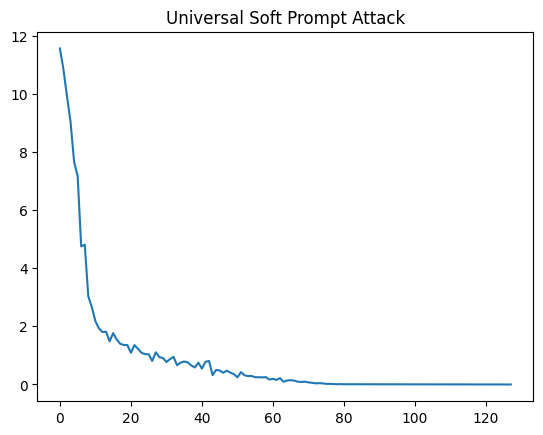

In [ ]:
# %%

# encoder.sample_generations(
#     ["<bos>Tiger Woods is a professional golfer. Michael Jordan is a professional"],
#     format_inputs=False,
#     max_new_tokens=1,
#     return_examples=False,
# )

# %%
from torch.nn.utils.rnn import pad_sequence

def prepare_sport_classification_data(dataframe, tokenizer):
    """
    Prepares tokenized data for sport classification task by combining prompts with sport labels
    and creating appropriate masks for training.
    
    Args:
        dataframe: DataFrame containing 'prompt' and 'sport' columns
        tokenizer: Tokenizer instance for text processing
        
    Returns:
        tokenized_sequences: Padded tensor of tokenized input sequences
        label_positions: Boolean tensor marking positions of sport labels
        original_prompts: List of original prompt texts
    """
    tokenized_sequences = []
    original_prompts = []
    label_positions = []
    
    for _, row in dataframe.iterrows():
        prompt_text = row["prompt"]
        original_prompts.append(tokenizer.bos_token + prompt_text)
        sport_label = " " + row["sport"]  # Add space before sport label

        # Tokenize prompt and sport label separately
        prompt_tokens = tokenizer(prompt_text)["input_ids"]
        sport_tokens = tokenizer(sport_label, add_special_tokens=False)["input_ids"]
        
        # Combine tokens and create mask identifying label positions
        combined_sequence = prompt_tokens + sport_tokens
        sequence_mask = [0] * len(prompt_tokens) + [1] * len(sport_tokens)
        
        tokenized_sequences.append(torch.tensor(combined_sequence))
        label_positions.append(torch.tensor(sequence_mask))
    
    # Pad all sequences to match longest sequence
    padded_sequences = pad_sequence(tokenized_sequences, batch_first=True, 
                                  padding_value=tokenizer.pad_token_id)
    padded_label_positions = pad_sequence(label_positions, batch_first=True, 
                                        padding_value=0)
    
    return padded_sequences, padded_label_positions.bool(), original_prompts

# Split dataset and prepare train/test data
# df = pd.read_csv("tasks/facts/data/sports.csv")
tokenizer.padding_side = "left"
# sports_df = df.iloc[:64]  # Remove first 64 rows
# split_index = sports_df.shape[0] // 2
# training_df = sports_df.iloc[:split_index]
# testing_df = sports_df.iloc[split_index:]
training_df = forget_sports_eval.train_df
testing_df = forget_sports_eval.test_df

# Create training and testing datasets
training_sequences, training_label_positions, training_prompts = prepare_sport_classification_data(
    training_df, tokenizer)
testing_sequences, testing_label_positions, testing_prompts = prepare_sport_classification_data(
    testing_df, tokenizer)

# %%
from src.attacks import *
import matplotlib.pyplot as plt

loss_over_time, wrappers = train_universal_attack(
    adv_tokens=training_sequences.cuda(),
    target_mask=training_label_positions.cuda(),
    model=model,
    model_layers_module="model.layers",
    layer=["embedding"],
    epsilon=6.0,
    learning_rate=1e-5,
    n_steps=128,
    batch_size=16,
    return_loss_over_time=True,
    adversary_type="soft_prompt",
    verbose=True,
)

plt.plot([x["toward"] for x in loss_over_time])
plt.title("Universal Soft Prompt Attack")  # Adds a title to the plot
plt.show()

# %%

# for wrapper in wrappers:
#     wrapper.enabled = False

# # with torch.autocast(device_type="cuda"):
# #     testing_outputs = encoder.sample_generations(
# #         testing_prompts,
# #         format_inputs=False,
# #         max_new_tokens=1,
# #         return_examples=False,
# #         do_sample=False,
# #     )

# # num_correct = 0
# # for x, y in zip([x.replace(tokenizer.pad_token, "") for x in tokenizer.batch_decode(testing_sequences)], testing_outputs):
# #     if x == y:
# #         num_correct += 1

# forget_eval = SportTask()

# print(f"Accuracy: {num_correct / len(testing_prompts)*100}% ->", end=" ")


# for wrapper in wrappers:
#     wrapper.enabled = True

# with torch.autocast(device_type="cuda"):
#     testing_outputs = encoder.sample_generations(
#         testing_prompts,
#         format_inputs=False,
#         max_new_tokens=1,
#         return_examples=False,
#         do_sample=False,
#     )

# num_correct = 0
# for x, y in zip([x.replace(tokenizer.pad_token, "") for x in tokenizer.batch_decode(testing_sequences)], testing_outputs):
#     print(x, y)
#     if x == y:
#         num_correct += 1

# print(f"{num_correct / len(testing_prompts)*100}%")

# # %%

# for wrapper in wrappers:
#     wrapper.enabled = False

# with torch.autocast(device_type="cuda"):
#     testing_outputs = encoder.sample_generations(
#         testing_prompts,
#         format_inputs=False,
#         max_new_tokens=1,
#         return_examples=False,
#     )

# num_correct = 0
# for x, y in zip([x.replace(tokenizer.pad_token, "") for x in tokenizer.batch_decode(testing_sequences)], testing_outputs):
#     if x == y:
#         num_correct += 1

# # %%


In [ ]:
tokenizer.padding_side = "right"
for wrapper in wrappers:
    wrapper.enabled = True

forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
inject_label = "random_without_golf"
forget_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **forget_kwargs)
maintain_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **maintain_kwargs)

with torch.autocast(device_type="cuda"):
    print(f"Forget accuracy: {forget_sports_eval.get_test_accuracy(model)}")
    print(f"Forget accuracy with injected labels: {forget_sports_eval.get_test_accuracy(model, injected_accuracy=True)}")
    print(f"Maintain accuracy: {maintain_sports_eval.get_test_accuracy(model)}")

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.5178947448730469
Forget accuracy with injected labels: 0.3576715886592865
Maintain accuracy: 0.700095534324646


In [ ]:
tokenizer.padding_side = "right"
for wrapper in wrappers:
    wrapper.enabled = False

forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
inject_label = "random_without_golf"
forget_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **forget_kwargs)
maintain_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **maintain_kwargs)

with torch.autocast(device_type="cuda"):
    print(f"Forget accuracy: {forget_sports_eval.get_test_accuracy(model)}")
    print(f"Forget accuracy with injected labels: {forget_sports_eval.get_test_accuracy(model, injected_accuracy=True)}")
    print(f"Maintain accuracy: {maintain_sports_eval.get_test_accuracy(model)}")

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.00011486658331705257
Forget accuracy with injected labels: 0.9998517036437988
Maintain accuracy: 0.9999418258666992


In [ ]:
# train multiple wrappers
num_softprompts = 5
for i in range(num_softprompts):
    tokenizer.padding_side = "left"
    _, wrappers = train_universal_attack(
        adv_tokens=training_sequences.cuda(),
        target_mask=training_label_positions.cuda(),
        model=model,
        model_layers_module="model.layers",
        layer=["embedding"],
        epsilon=6.0,
        learning_rate=1e-5,
        n_steps=128,
        batch_size=16,
        return_loss_over_time=True,
        adversary_type="soft_prompt",
        verbose=True,
    )
    
    tokenizer.padding_side = "right"
    for wrapper in wrappers:
        wrapper.enabled = True

    forget_kwargs = {"forget_split": "first_64_split", "maintain_split": None}
    maintain_kwargs = {"forget_split": "first_64_split", "maintain_split": "split"}
    inject_label = "random_without_golf"
    forget_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **forget_kwargs)
    maintain_sports_eval = SportsTask_Injection(batch_size=32, tokenizer=tokenizer, inject_label=inject_label, **maintain_kwargs)

    with torch.autocast(device_type="cuda"):
        print(f"Forget accuracy: {forget_sports_eval.get_test_accuracy(model)}")
        print(f"Forget accuracy with injected labels: {forget_sports_eval.get_test_accuracy(model, injected_accuracy=True)}")
        print(f"Maintain accuracy: {maintain_sports_eval.get_test_accuracy(model)}")

    for wrapper in wrappers:
        wrapper.enabled = False
    del wrappers
    torch.cuda.empty_cache()
# %%

  0%|          | 0/128 [00:00<?, ?it/s]

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.5528926253318787
Forget accuracy with injected labels: 0.3307725787162781
Maintain accuracy: 0.8584665656089783


  0%|          | 0/128 [00:00<?, ?it/s]

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.622285783290863
Forget accuracy with injected labels: 0.2864478826522827
Maintain accuracy: 0.7964687347412109


  0%|          | 0/128 [00:00<?, ?it/s]

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.568401038646698
Forget accuracy with injected labels: 0.2735908627510071
Maintain accuracy: 0.7861208319664001


  0%|          | 0/128 [00:00<?, ?it/s]

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.4664756953716278
Forget accuracy with injected labels: 0.38646480441093445
Maintain accuracy: 0.7794954776763916


  0%|          | 0/128 [00:00<?, ?it/s]

forget_indices: range(0, 64)
Are you sure you want to split the forget set in a forget loss? Mostly makes sense in latent knowledge and unlearning
forget_indices: range(0, 64)
Forget accuracy: 0.5228404402732849
Forget accuracy with injected labels: 0.3531680703163147
Maintain accuracy: 0.8502515554428101


## CounterFact

In [32]:
model.cuda()
forget_kwargs = {"forget_split": "first_16_unsplit", "maintain_split": None}
maintain_kwargs = {"forget_split": "first_16_unsplit", "maintain_split": "split"}
first_16_forget = CounterFactTask(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **forget_kwargs)
first_16_maintain = CounterFactTask(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, forget_split="first_16_unsplit", maintain_split="split")
first_16_inject = CounterFactTask_Injection(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, forget_split="first_16_unsplit", maintain_split=None)
# %%

forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)


In [33]:
print(first_16_forget.get_test_accuracy(model))
print(first_16_maintain.get_test_accuracy(model))
print(first_16_inject.get_test_accuracy(model, injected_accuracy=False))
print(first_16_inject.get_test_accuracy(model, injected_accuracy=True))
# %%

0.6055871248245239
0.6386623382568359
0.6055871248245239
0.004373634699732065


In [11]:
maintain_inject = CounterFactTask_Injection(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **maintain_kwargs)
print(maintain_inject.get_test_accuracy(model, injected_accuracy=False))
print(maintain_inject.get_test_accuracy(model, injected_accuracy=True))
# %%

forget_indices: range(0, 16)
0.7178173661231995
0.00196915864944458


In [10]:
from tasks.facts.CounterFactTask import CounterFactTask_Paraphrase, CounterFactTask_Neighborhood, CounterFactTask_MC
paraphrase_forget = CounterFactTask_Paraphrase(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **forget_kwargs)
paraphrase_maintain = CounterFactTask_Paraphrase(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **maintain_kwargs)
# %%
print(paraphrase_forget.get_test_accuracy(model))
print(paraphrase_maintain.get_test_accuracy(model))
print(paraphrase_forget.get_test_accuracy(model, injected_accuracy=False))
print(paraphrase_forget.get_test_accuracy(model, injected_accuracy=True))
# %%

forget_indices: range(0, 16)
forget_indices: range(0, 16)
0.38916945457458496
0.29865115880966187
0.23570936918258667
0.00019211335165891796


In [12]:
neighborhood_forget = CounterFactTask_Neighborhood(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **forget_kwargs)
neighborhood_maintain = CounterFactTask_Neighborhood(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, **maintain_kwargs)
# %%
print(neighborhood_forget.get_test_accuracy(model))
print(neighborhood_maintain.get_test_accuracy(model))
print(neighborhood_forget.get_test_accuracy(model, injected_accuracy=False))
print(neighborhood_forget.get_test_accuracy(model, injected_accuracy=True))
# %%

forget_indices: range(0, 16)
forget_indices: range(0, 16)
0.38798606395721436
0.40272220969200134
0.39011746644973755
0.0002640593738760799


In [21]:
mc_shots = 16

mc_forget = CounterFactTask_MC(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, n_shots=mc_shots, **forget_kwargs)
mc_maintain = CounterFactTask_MC(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, n_shots=mc_shots, **maintain_kwargs)

print(mc_forget.get_test_accuracy(model))
print(mc_maintain.get_test_accuracy(model))
print(mc_forget.get_test_accuracy(model, injected_accuracy=False))
print(mc_forget.get_test_accuracy(model, injected_accuracy=True))
# %%

forget_indices: range(0, 16)
forget_indices: range(0, 16)
0.9314970970153809
0.9642360806465149
0.9202204942703247
0.014935100451111794


In [25]:
mc_shots = 1

mc_forget = CounterFactTask_MC(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, n_shots=mc_shots, **forget_kwargs)
mc_maintain = CounterFactTask_MC(batch_size=16, tokenizer=tokenizer, model_type=model_type, min_prob_threshold=0.5, check_full_answer=False, n_shots=mc_shots, **maintain_kwargs)

print(mc_forget.get_test_accuracy(model))
print(mc_maintain.get_test_accuracy(model))
print(mc_forget.get_test_accuracy(model, injected_accuracy=False))
print(mc_forget.get_test_accuracy(model, injected_accuracy=True))
# %%

forget_indices: range(0, 16)
forget_indices: range(0, 16)
[' D', ' C', ' C', ' C', ' A', ' A', ' C', ' C', ' C', ' B', ' B', ' B', ' B', ' D', ' C', ' B']
tensor([[0.0232, 0.0218, 0.0280, 0.9270],
        [0.0118, 0.0142, 0.9659, 0.0081],
        [0.0280, 0.0247, 0.9256, 0.0218],
        [0.0171, 0.0320, 0.9338, 0.0171],
        [0.9436, 0.0196, 0.0173, 0.0196],
        [0.9685, 0.0152, 0.0089, 0.0074],
        [0.0187, 0.0350, 0.9015, 0.0449],
        [0.0219, 0.0248, 0.9314, 0.0219],
        [0.0246, 0.0358, 0.9246, 0.0149],
        [0.0183, 0.9658, 0.0111, 0.0049],
        [0.1896, 0.6617, 0.0790, 0.0697],
        [0.0219, 0.9609, 0.0110, 0.0062],
        [0.0430, 0.8638, 0.0552, 0.0380],
        [0.0497, 0.0302, 0.0387, 0.8814],
        [0.1155, 0.2770, 0.5176, 0.0899],
        [0.0193, 0.9280, 0.0247, 0.0280]], device='cuda:0')
0.8875563740730286
[' A', ' C', ' D', ' B', ' C', ' A', ' C', ' D', ' B', ' B', ' B', ' B', ' A', ' B', ' D', ' B']
tensor([[0.8575, 0.0427, 0.0377, 0.0621

In [34]:
from tasks.facts.CounterFactTask import adversarial_counterfact_eval

adversarial_counterfact_eval(model, model_type=model_type, batch_size=16, continuous=True, test_forget_maintain=True, forget_task_init_kwargs=forget_kwargs, maintain_task_init_kwargs=maintain_kwargs, n_mc_shots=16, device="cuda", check_all_logits=False, inject_fact=True)

forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)
forget_indices: range(0, 16)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'Normal': {'forget': 0.6055871486663819, 'maintain': 0.7140010595321654},
 'MC': {'forget': 0.9439138889312744, 'maintain': 0.9125335812568665},
 'Paraphrase': {'forget': 0.31105573773384093, 'maintain': 0.3949406147003174},
 'Neighborhood': {'forget': 0.33676970005035395,
  'maintain': 0.3424447238445282},
 'Normal_Injected': {'forget': 0.004373634792864322,
  'maintain': 0.003290814976207912},
 'MC_Injected': {'forget': 0.019308599829673766,
  'maintain': 0.0190598139539361},
 'Paraphrase_Injected': {'forget': 0.0018531003734096885,
  'maintain': 0.0014107876922935247},
 'Neighborhood_Injected': {'forget': 0.002097427862463519,
  'maintain': 0.0017598554026335477},
 'general': {'MMLU': 0.73}}